In [3]:
# Imports

import keras
from keras import backend as K
from keras.layers import Conv1D, LeakyReLU, Dropout, Activation, concatenate, Input, add
from keras.models import Model

from keras.utils import plot_model
from IPython.display import Image

In [4]:
import tensorflow as tf

In [5]:
def create_model_t(a):
    
    X = a
    x = X
    
    x = Conv1D(filters=128, kernel_size=65, padding='same', dilation_rate=2,
               activation=None, kernel_initializer='Orthogonal')(x)
    D = LeakyReLU(0.2)(x)
    
    x = Conv1D(filters=512, kernel_size=9, padding='same', dilation_rate=2,
               activation=None, kernel_initializer='Orthogonal')(D)
    x = Dropout(0.5)(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv1D(filters=128, kernel_size=65, padding='same', activation=None,
               kernel_initializer='Orthogonal')(x)
    x = Dropout(0.5)(x)
    U = Activation('relu')(x)
#     x = SubPixel1D(x, r=2)

    # Concatenate here
    x = concatenate([D, U])
    
    x = Conv1D(filters=2, kernel_size=9, padding='same', activation=None)(x)
    
    out = add([x, X])
#     out = x
    
    model = Model(inputs=a, outputs=out)
    
    return model

In [18]:
def create_model(inp):
    
    x = inp
    
    # Number of layers (double check this parameter)
    L = 4
    
#     # Number of filters/kernels, etc
#     n_filters = [128, 256, 512, 512, 512, 512, 512, 512]
#     n_filtersizes = [65, 33, 17, 9, 9, 9, 9, 9, 9]
    n_filters = [128, 256, 512, 512]
    n_filtersizes = [65, 33, 17, 9]
#     n_filters = [128, 256, 512, 512, 512]
#     n_filtersizes = [65, 33, 17, 9, 9]
    
    downsampling_l = []
    
    print('Building the model...')
    
    print('Downsampling layers')
    for l, nf, fs in zip(range(L), n_filters, n_filtersizes):
        x = Conv1D(filters=nf, kernel_size=fs, padding='same', dilation_rate=2,
                   activation=None, kernel_initializer='Orthogonal')(x)
        x = LeakyReLU(0.2)(x)
        print('D-Block: ', x.get_shape())
        downsampling_l.append(x)
    
    print('Bottleneck layer')
    x = Conv1D(filters=n_filters[-1], kernel_size=n_filtersizes[-1], padding='same',
               dilation_rate=2, activation=None, kernel_initializer='Orthogonal')(x)
    x = Dropout(0.5)(x)
    x = LeakyReLU(0.2)(x)
    print('Botneck: ', x.get_shape())
    
    # Lists reversed here
    n_filters.reverse()
    n_filtersizes.reverse()
    downsampling_l.reverse()
    
    print('Upsampling layers')
    for l, nf, fs, l_in in zip(range(L), n_filters, n_filtersizes, downsampling_l):
        x = Conv1D(filters=nf, kernel_size=fs, padding='same', activation=None,
                   kernel_initializer='Orthogonal')(x)
        x = Dropout(0.5)(x)
        x = Activation('relu')(x)
        x = SubPixel1D(x, r=2)
        print('Bef con: ', x.get_shape())
        x = concatenate([x, l_in], axis=-1)
        print('U-Block: ', x.get_shape())
    
    print('Final layer')
    x = Conv1D(filters=2, kernel_size=9, padding='same', activation=None)(x)
    x = SubPixel1D(x, r=2)
    print('Output:  ', x.get_shape())
    
    outp = add([x, inp])
    
    model = Model(inputs=inp, outputs=outp)
    
    return model

CNN 1D Model Shapes

Model: (len(registro), 1)

Fitting: (nº registros, len(registro), 1)

In [19]:
#a = keras.layers.Input(shape=(1024, 1))
a = keras.layers.Input(shape=(32666, 1))
# a = keras.layers.Input(shape=(1, 1024))

model = create_model(a)

Building the model...
Downsampling layers
D-Block:  (?, 32666, 128)
D-Block:  (?, 32666, 256)
D-Block:  (?, 32666, 512)
D-Block:  (?, 32666, 512)
Bottleneck layer
Botneck:  (?, 32666, 512)
Upsampling layers
Bef con:  (?, 65332, 256)


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 65332, 256), (None, 32666, 512)]

In [16]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32666, 1)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 32666, 128)   8448        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 32666, 128)   0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 32666, 256)   1081600     leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

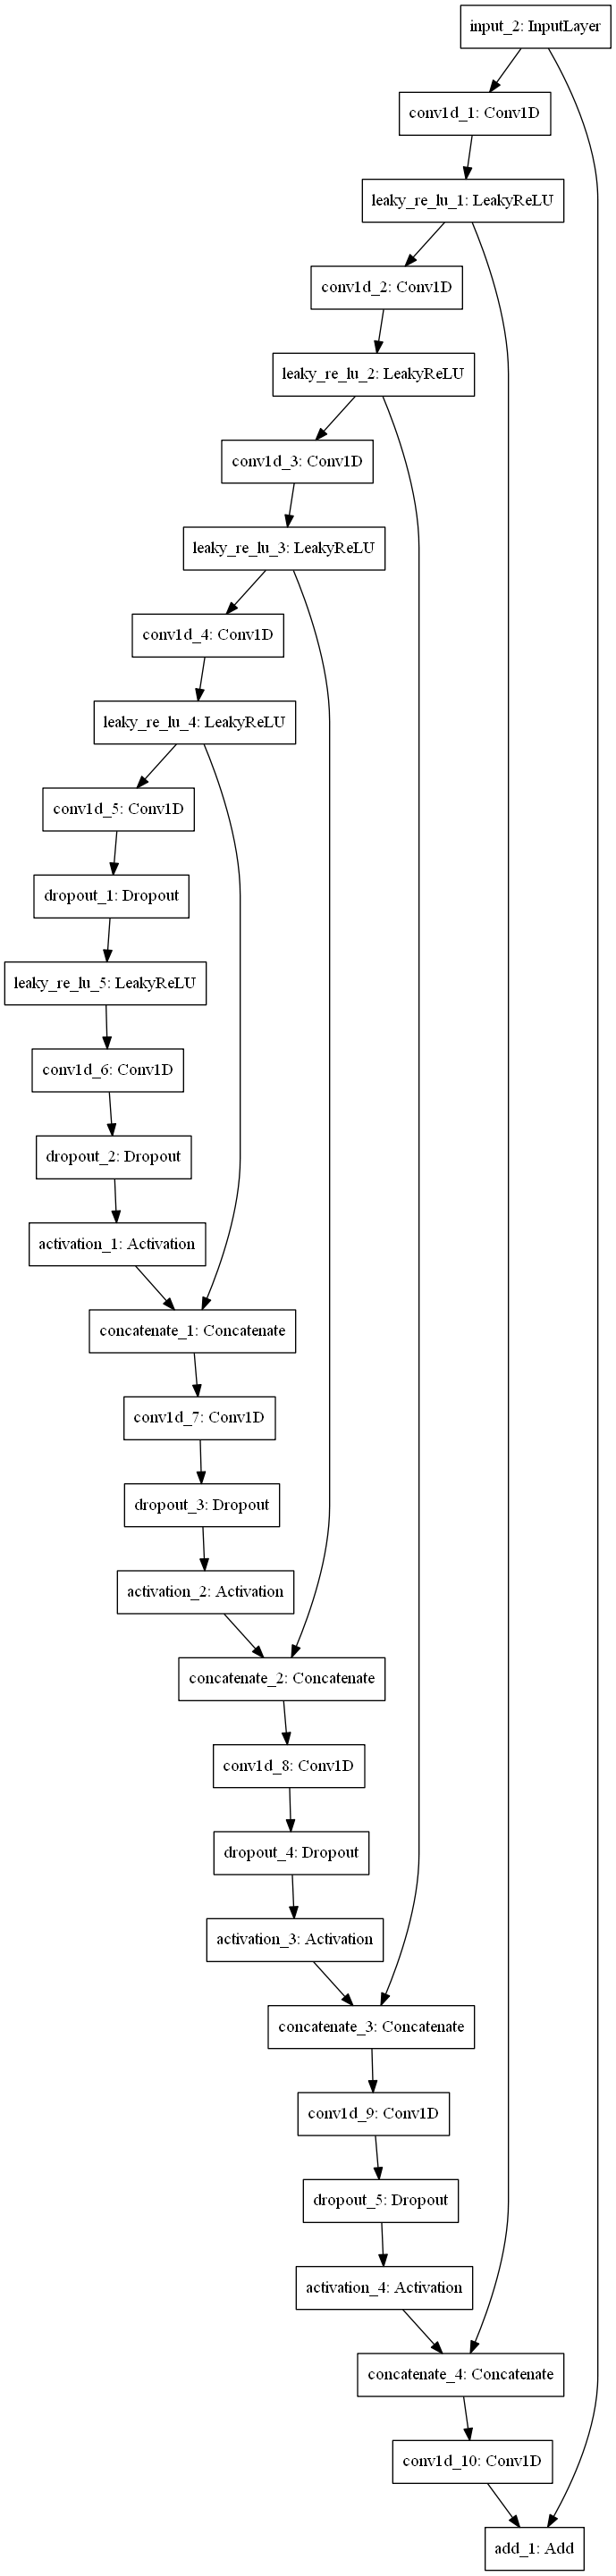

In [14]:
plot_model(model, to_file='model.png')
Image(filename='model.png', retina=True)

In [15]:
def SubPixel1D(I, r):
    
    # Assumming input has dim (batch, width, r)
    with K.name_scope('subpixel'):
        X = tf.transpose(I, [2,1,0]) # (r, w, b)
        X = tf.batch_to_space_nd(X, [r], [[0,0]]) # (1, r*w, b)
        X = tf.transpose(X, [2,1,0])
        
        return X

In [ ]:
model = create_model()

## Backup model 2

In [ ]:
# def create_model_c(a):
    
#     # Create inputs (using placeholders)
#     # X = K.placeholder(shape=(None, None, 1), name='X')
    
#     X = a
#     x = X
    
#     # Number of layers (double check this parameter)
#     L = 4
    
# #     # Number of filters/kernels, etc
# #     n_filters = [128, 256, 512, 512, 512, 512, 512, 512]
# #     n_filtersizes = [65, 33, 17, 9, 9, 9, 9, 9, 9]
#     n_filters = [128, 256, 512, 512]
#     n_filtersizes = [65, 33, 17, 9]
# #     n_filters = [128, 256, 512, 512, 512]
# #     n_filtersizes = [65, 33, 17, 9, 9]
#     downsampling_l = []
    
#     print('Building the model...')
    
#     print('Downsampling layers')
#     # Downsampling step
#     for l, nf, fs in zip(range(L), n_filters, n_filtersizes):
#         # Name_scope here
# #         with K.name_scope('downsc_conv%d' % l):
#         # I think that: border_mode=padding, init=kernel_initializer, subsabmple_length=dilation_rate
#         x = Conv1D(filters=nf, kernel_size=fs, padding='same', dilation_rate=2,
#                    activation=None, kernel_initializer='Orthogonal')(x)
#         x = LeakyReLU(0.2)(x)
#         print('D-Block: ', x.get_shape())
#         downsampling_l.append(x)
             
#     print('Bottleneck layer')
# #     Bottleneck step
# #     with K.name_scope('bottleneck_conv'):
#     x = Conv1D(filters=n_filters[-1], kernel_size=n_filtersizes[-1], padding='same',
#                dilation_rate=2, activation=None, kernel_initializer='Orthogonal')(x)
#     x = Dropout(0.5)(x)
#     x = LeakyReLU(0.2)(x)
#     print('Botneck: ', x.get_shape())
        
#     # Reverse here the lists
#     n_filters.reverse()
#     n_filtersizes.reverse()
#     downsampling_l.reverse()
        
#     print('Upsampling layers')
#     # Upsampling step
#     # Reverse all vectors before this for
#     for l, nf, fs, l_in in zip(range(L), n_filters, n_filtersizes, downsampling_l):
# #         with K.name_scope('upsc_conv%d' % l):
#         x = Conv1D(filters=2*nf, kernel_size=fs, padding='same', activation=None,
#                    kernel_initializer='Orthogonal')(x)
#         x = Dropout(0.5)(x)
#         x = Activation('relu')(x)
# #         x = SubPixel1D(x, r=2)
#         x = concatenate([x, l_in], axis=-1)
#         print('U-Block: ', x.get_shape())
      
#     print('Final layer')
#     # Final convolution layer
# #     with K.name_scope('lastconv'):
#     x = Conv1D(filters=2, kernel_size=9, padding='same', activation=None)(x)
# #     x = SubPixel1D(x, r=2)
#     print('Output:  ', x.get_shape())
    
#     g = add([x, X])
    
#     out = g
    
#     model = Model(inputs=a, outputs=out)
    
#     return model

## Backup model 1

In [5]:
# def create_model():
    
#     # Create inputs (using placeholders)
#     # X = K.placeholder(shape=(None, None, 1), name='X')
    
#     X = Input(shape=(None, 1))
#     x = X
    
#     print(type(x))
    
#     # Number of layers (double check this parameter)
#     L = 4
    
# #     # Number of filters/kernels, etc
# #     n_filters = [128, 256, 512, 512, 512, 512, 512, 512]
# #     n_filtersizes = [65, 33, 17, 9, 9, 9, 9, 9, 9]
#     n_filters = [128, 256, 512, 512]
#     n_filtersizes = [65, 33, 17, 9]
#     downsampling_l = []
    
#     print('Building the model...')
    
#     # Downsampling step
#     for l, nf, fs in zip(range(L), n_filters, n_filtersizes):
#         # Name_scope here
#         with K.name_scope('downsc_conv%d' % l):
#             # I think that: border_mode=padding, init=kernel_initializer, subsabmple_length=dilation_rate
#             x = Conv1D(filters=nf, kernel_size=fs, padding='same', dilation_rate=2,
#                        activation=None, kernel_initializer='Orthogonal')(x)
#             x = LeakyReLU(0.2)(x)
# #             print('D-Block: ', x.get_shape())
# #             print('D-Block: ', x.shape)
#             downsampling_l.append(x)
            
#     # Bottleneck step
#     with K.name_scope('bottleneck_conv'):
#         x = Conv1D(filters=n_filters[-1], kernel_size=n_filtersizes[-1], padding='same',
#                    dilation_rate=2, activation=None, kernel_initializer='Orthogonal')(x)
#         x = Dropout(0.5)(x)
#         x = LeakyReLU(0.2)(x)
# #         print('Botneck: ', x.get_shape())
        
        
#     # Reverse here the lists
#     n_filters.reverse()
#     n_filtersizes.reverse()
#     downsampling_l.reverse()
        
#     # Upsampling step
#     # Reverse all vectors before this for
#     for l, nf, fs, l_in in zip(range(L), n_filters, n_filtersizes, downsampling_l):
#         with K.name_scope('upsc_conv%d' % l):
#             x = Conv1D(filters=2*nf, kernel_size=fs, padding='same', activation=None,
#                        kernel_initializer='Orthogonal')(x)
#             x = Dropout(0.5)(x)
#             x = Activation('relu')(x)
#             print(type(x))
#             x = SubPixel1D(x, r=2)
#             #x = merge([x, l_in], mode='concat', concat_axis=-1)
#             print(type(x))
#             x = Concatenate([x, l_in])
#             print(type(x))
# #             print('U-Block: ', x.shape)
            
#     # Final convolution layer
#     with K.name_scope('lastconv'):
#         x = Conv1D(filters=2, kernel_size=9, padding='same', activation=None)(x)
#         x = SubPixel1D(x, r=2)
# #         print('Output:  ',x.shape)
        
#     # Merge x w X as g
#     # return g
    
#     return x